In [12]:
import numpy as np
from tqdm import tqdm
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf

from DDGAUGAN import Predictor

In [13]:
predictor = Predictor('trained_models/image_generator_model.h5', 'trained_models/image_encoder_model.h5')

In [14]:
generator = predictor.gen
sampler = predictor.sampler
encoder = predictor.encoder

In [15]:
generator.trainable = False

libpng warning: iCCP: known incorrect sRGB profile


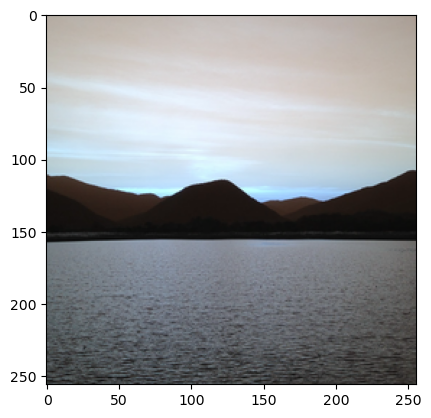

In [42]:
target_path = 'data/lhq/images/0000015.png'
target = cv2.imread(target_path)

target_prepared = target / 127.5 - 1
target_prepared = target_prepared[np.newaxis, ...]

plt.imshow(target)

In [17]:
from transformers import SegformerFeatureExtractor, SegformerForSemanticSegmentation

feature_extractor = SegformerFeatureExtractor.from_pretrained("nvidia/segformer-b0-finetuned-ade-512-512")
model = SegformerForSemanticSegmentation.from_pretrained("nvidia/segformer-b0-finetuned-ade-512-512")

In [18]:
def image_to_mask(images, model, feature_extractor):
    inputs = feature_extractor(images=images, return_tensors="pt")
    outputs = model(**inputs)
    logits = outputs.logits
    data: np.ndarray = np.array(logits.detach().numpy()).transpose((0, 2, 3, 1))
    image_mask = np.argmax(data, axis=-1, keepdims=True)
    image_mask = np.repeat(np.repeat(image_mask, 2, axis=1), 2, axis=2)
    return image_mask.astype(np.uint8)[0]

In [19]:
from scipy.ndimage import maximum_filter

def filter(map):
    fmaps = cv2.medianBlur(map, 13)[..., np.newaxis]
    unique, counts = np.unique(fmaps, return_counts=True)
    pmax_val = unique[np.argmax(counts)]
    for u, c in zip(unique, counts):
        if c < 1000:
            fmaps[fmaps == u] = 0
    fmaps = maximum_filter(fmaps, 5)
    return fmaps

In [20]:
import pandas as pd

def parse_csv(path: str, sep: str = ';'):
    csv = pd.read_csv(path, sep=sep)
    classes = {}
    for index, (name, inc) in enumerate(zip(csv['Name'], csv['Include'])):
        if inc:
            classes[name] = index
    return classes

classes = parse_csv('data/included_classes.csv')

In [21]:
def transform_map(map):
    map = np.array(map)
    if len(map.shape) == 3:
        map = map[..., 0:1]
    else:
        map = map[..., np.newaxis]
    x = np.zeros_like(map, dtype=np.uint8)
    for i, val in enumerate(classes.values()):
        x[map == val + 0] = i + 1
    return x

(1,)


In [79]:
from keras import utils

labels = image_to_mask(target, model, feature_extractor)
labels = filter(labels)
labels = transform_map(labels)
labels = utils.to_categorical(labels, 25)
labels = labels[np.newaxis, ...].astype(np.float32)

In [37]:
labels.shape, labels.dtype

((1, 256, 256, 25), dtype('float32'))

In [33]:
noise = tf.Variable(initial_value=tf.random.normal(shape=(1, 256)), trainable=True)

In [ ]:
from GAUGAN import VGGFeatureMatchingLoss
from tensorflow.keras.losses import MeanSquaredError

num_iterations = 100_000

optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

perceptual_loss = VGGFeatureMatchingLoss()
mse_loss = MeanSquaredError()

iterator = tqdm(range(num_iterations))
for iteration in iterator:
    with tf.GradientTape() as tape:
        prediction = generator([noise, labels])
        loss_value = mse_loss(prediction, target_prepared)
        
    gradients = tape.gradient(loss_value, [noise])
    optimizer.apply_gradients(zip(gradients, [noise]))
    
    iterator.set_postfix_str(f'Loss: {loss_value.numpy()}')
    if iteration % 100 == 0:
        learned_image = (generator([noise, labels]) + 1) * 127.5
        learned_image = np.array(learned_image, np.uint8)
        plt.imshow(learned_image[0])
        plt.show()

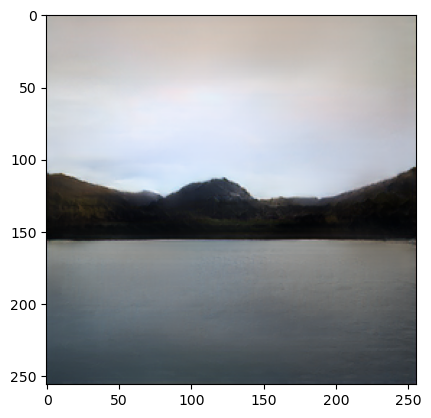

In [80]:
learned_image = (generator([noise, labels]) + 1) * 127.5
learned_image = np.array(learned_image, np.uint8)
plt.imshow(learned_image[0])

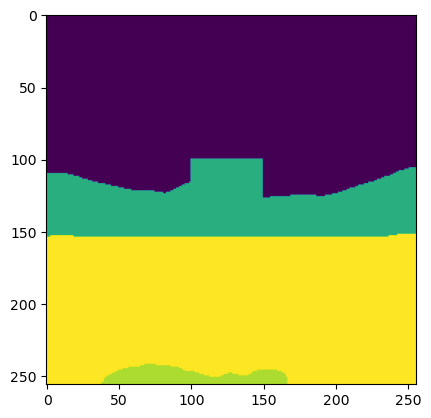

In [104]:
# sky: 2
# mountains: 7
# see: 10
edited_labels = np.array(labels)
edited_labels[0, 100:150, 100:150, :] = [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
plt.imshow(edited_labels.argmax(axis=-1)[0])

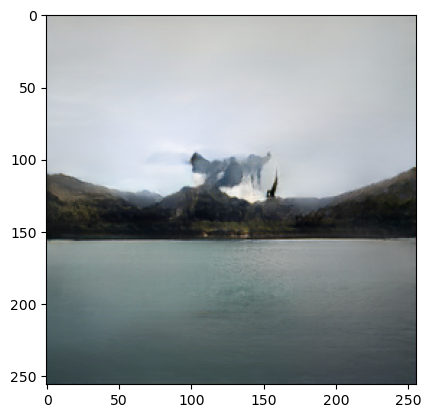

In [105]:
learned_image = (generator([noise, edited_labels]) + 1) * 127.5
learned_image = np.array(learned_image, np.uint8)
plt.imshow(learned_image[0])